# Project Milestone P2

### Objective

This notebook is a creative extension concerning the article _Comparing Random Forest with Logistic Regression for
Predicting Class-Imbalanced Civil War Onset Data_ by D.Muchlinski et al (2016).
We aim to TODO

### Libraries

- Scikit-learn
- Numpy
- Pandas
- Matplotlib
- Seaborn

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

## 1. Data Loading and preparation

In [10]:
replication_features = ["warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]

data = pd.read_csv('data/SambnisImp.csv', usecols=replication_features)

# Retreiving the labels
y = data['warstds']
X = data.drop('warstds', axis=1)

print('Nb of country-years: {}'.format(len(X)))
X.head()

Nb of country-years: 7140


,ptime,autonomy,popdense,army85,milper,trade,nmgdp,autch98,demch98,polch98,...,mirps1,mirps2,mirps3,sxpsq,pol4sq,decade1,decade2,decade3,decade4,proxregc
0,12,0.005151,118.554791,129472.9042,121.087366,72.881375,4508.131692,0,0,0,...,0.16935,0.313143,0.373714,0.052989,61.493014,0,0,0,0,0.143299
1,24,0.000000,117.756342,129413.0225,121.885359,72.900089,4491.340308,0,0,0,...,0.00000,1.000000,0.000000,0.052663,100.000000,0,0,0,0,1.000000
2,36,0.000000,118.280656,130431.0145,122.780608,72.962880,4484.267686,0,0,0,...,0.00000,1.000000,0.000000,0.052891,100.000000,0,0,0,0,1.000000
3,48,0.000000,118.325869,126781.6866,118.256427,73.102449,4474.082672,0,0,0,...,0.00000,1.000000,0.000000,0.052902,100.000000,0,0,0,0,1.000000
4,60,0.000000,118.312296,130979.2470,122.245074,72.850389,4497.299503,0,0,0,...,0.00000,1.000000,0.000000,0.052706,100.000000,0,0,0,0,1.000000


In [11]:
# We verify no data is missing
len(X[X.isna().any(axis=1)])

0

Let us reproduce Figure 2 from the article, this will serve as a comparison point for our extensions.
In the article, Random Forests are compared to "against three well-known logistic models of civil war onset", namely those developped by:
- Collier and Hoeffler (2004) 
- Fearon and Laitin (2003)
- Hegre and Sambanis (2006).

Let us load the corresponding features.

In [12]:
#Fearon and Laitin (2003) 
FL_features = ["warhist", "ln_gdpen", "lpopns", "lmtnest", "ncontig", "oil",
               "nwstate", "inst3", "pol4", "ef", "relfrac"] 
X_FL = X[FL_features]

#Collier and Hoeffler (2004)
CH_features = ["sxpnew", "sxpsq", "ln_gdpen", "gdpgrowth","warhist", "lmtnest",
               "ef", "popdense", "lpopns", "coldwar", "seceduc","ptime"]
X_CH = X[CH_features]

#Hegre and Sambanis (2006) 
HS_features = ["lpopns", "ln_gdpen", "inst3", "parreg", "geo34",
    "proxregc", "gdpgrowth", "anoc", "partfree", "nat_war", "lmtnest",
    "decade1", "pol4sq", "nwstate", "regd4_alt", "etdo4590", "milper", "geo1",
    "tnatwar", "presi"]
X_HS = X[HS_features]

## 2. Fitting and comparing the models

We will run all three different logistic models through two methods each, namely a regular and a L2-penalized, logistic regressions. Note here that L2 regularization is used instead of Firth regularization which is the one used in the article. We justify this choice by arguing that the main idea of the paper was using penalty to adjust regression to the rare events, and thus it is not important which penalty it is.

In [13]:
# Creating the methods
logistic = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000)
logistic_pen = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
gbc = GradientBoostingClassifier()
random_forest = RandomForestClassifier(n_estimators=1000)
mlp = MLPClassifier(max_iter = 1000)

In [6]:
def compare_models_aucs(model_1, model_dataset_1, model_2, model_dataset_2, y, cv=10):
    model_1_aucs = cross_val_score(model_1, model_dataset_1, y, cv=cv, scoring="roc_auc")
    model_2_aucs = cross_val_score(model_2, model_dataset_2, y, cv=cv, scoring='roc_auc')
    return stats.kstest(model_1_aucs, model_2_aucs)

In [ ]:
compare_models_aucs(gbc, X, random_forest, X, y, cv=2)

In [ ]:
def draw_roc_on_ax(ax, fpr, tpr, model_name):
    # Compute the area under the fpt-tpf curve
    auc_score = auc(fpr, tpr)
    # Plotting results
    ax.plot(fpr, tpr, label='{}: {:.2f}'.format(model_name, auc_score))

In [ ]:
def plot_multi_roc(titles, logistic_methods, logistic_models, logistic_models_names, other_classifiers, other_classifiers_names, other_classifiers_dataset , y):
    fig, axes = plt.subplots(1,len(logistic_methods), figsize=(len(logistic_methods)*6.5,5))
    
    # Computing random classifiers' prediction only once
    classifiers_y_preds = []
    for classifier_name, classifier in zip(other_classifiers_names, other_classifiers):
        dataset = other_classifiers_dataset
        
        if classifier_name == "Multilayer perceptron":
            scaler = StandardScaler()
            scaler.fit(other_classifiers_dataset)
            dataset = scaler.transform(other_classifiers_dataset)
            
        classifiers_y_preds.append((classifier_name, cross_val_predict(classifier, dataset, y, cv=10, method="predict_proba")))
    
    if(len(logistic_methods)) > 1:
        for ax, title, logistic_method in zip(axes.flatten(), titles, logistic_methods):
            for classifier_name, classifier_y_pred in classifiers_y_preds:
                fpr, tpr, _ = roc_curve(y, classifier_y_pred[:, 1])
                draw_roc_on_ax(ax, fpr, tpr, classifier_name)
            for logistic_model, logistic_model_name in zip(logistic_models, logistic_models_names):
                y_pred = cross_val_predict(logistic_method, logistic_model, y, cv=10, method="predict_proba")
                # Compute the False Positive Rate and True Positive Rate
                fpr, tpr, _ = roc_curve(y, y_pred[:, 1])
                draw_roc_on_ax(ax, fpr, tpr, logistic_model_name)
            ax.set_title(title)
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend()
    else:
        for classifier_name, classifier_y_pred in classifiers_y_preds:
            fpr, tpr, _ = roc_curve(y, classifier_y_pred[:, 1])
            draw_roc_on_ax(axes, fpr, tpr, classifier_name)
        for logistic_model, logistic_model_name in zip(logistic_models, logistic_models_names):
            y_pred = cross_val_predict(logistic_methods[0], logistic_model, y, cv=10, method="predict_proba")
            # Compute the False Positive Rate and True Positive Rate
            fpr, tpr, _ = roc_curve(y, y_pred[:, 1])
            draw_roc_on_ax(axes, fpr, tpr, logistic_model_name)
        axes.set_title(titles[0])
        axes.set_xlabel("False Positive Rate")
        axes.set_ylabel("True Positive Rate")
        axes.legend()

In [ ]:
# Methods
titles = ['ROC curves']
logistic_methods = [logistic_pen]

# Models
logistic_models = [X_HS]
logistic_models_names = ['Hegre and Sambanis (Penalized Logits)']

other_classifiers = [random_forest, gbc, mlp]
other_classifiers_names = ["Random Forest", "Gradient Boosting Classifier", "Multilayer perceptron"]


# Fitting models and plotting results
plot_multi_roc(titles, logistic_methods, logistic_models, logistic_models_names, other_classifiers, other_classifiers_names, X, y)

From the first two graphs, one can easily recognise the results of the orinial paper (TODO std of AUC to justify minor diff inside CI ?). Indeed, when transitioning from uncorrected logits to penalized logits, we observe that the AUC score for Random Forest, Fearon & Laitin, and Hegre & Sambanis do not (or barely) change, while the AUC score for Collier & Hoeffler diminishes substantially.

TODO comment on gradient boosted classifier

## 3. Resampling data with SMOTE

One of our proposals is to use resampling techniques and study their effect on both the linear models and the random forest techniques. Indeed, it may well be that the poor performance of linear models relative to random forest is due to the severe imbalance of the CWD (roughly a 1:100 ratio).
To tackle this, we intend to use one of the most commonly used oversampling methods: the SMOTE (Synthetic Minority Oversampling Technique).

The SMOTE creates new instances of the minority class, and makes use of the K-nearest neighbors procedure to do so. The algorithm loops through all the "real" minority class instances. At each iteration, it finds its K nearest neighbors, and then creates "synthetic" minority class instances in the interval between the "real" instance and its "real" neighbors, such that the new instances are convex combination of the original instance and one of its neighbors. The procedure can be visualised in the following images ([source](https://rikunert.com/SMOTE_explained)).

<img src="img/SMOTE_1.png" width=600>

<img src="img/SMOTE_2.png" width=600>

In our problem, the number of genereated instances is such that the classes are balanced after resampling. 

In [ ]:
print("Before SMOTE, counts of labels 'warstds' ('1': {}, '0': {}".format(sum(y==1), sum(y==0)))

sm = SMOTE()
X_res, y_res = sm.fit_sample(X, y.ravel())

print("After SMOTE, counts of labels 'warstds' ('1': {}, '0': {}".format(sum(y_res==1), sum(y_res==0)))

We are interested in testing whether the fact of training on balanced data is enough to increase the predictive power of the Random Forest and the logistic regression in both normal and L1-penalized versions.

For this, we split our data between a training and testing set, and then proceed to train each model twice: once on the raw training data and once on a SMOTE-resampled version. Both versions of each trained model are then tested on test set, which remained unbalanced. Testing is done by computing the F1 score.

In [ ]:
# Creating the methods
logistic = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000)
logistic_pen = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
random_forest = RandomForestClassifier(n_estimators=400)

# Methods
methods_names = ['Uncorrected Logits', 'Penalized Logits', 'Random Forest']
methods = [logistic, logistic_pen, random_forest]

def pre_post_SMOTE_score(score, method, model_features, X_train, X_train_sm, y_train, y_train_sm, X_test, y_test):
    """
    Obtain demanded score on test set for model trained on raw data, and for model trained on resampled data
    """
    X_test = X_test[model_features]
    
    # 1. No resampling
    X_train = X_train[model_features]
    F1_raw = score(y_test, method.fit(X_train, y_train).predict(X_test))

    # 2. Using SMOTE
    X_train_sm = X_train_sm[model_features]
    F1_sm = score(y_test, method.fit(X_train_sm, y_train_sm).predict(X_test))    

    return F1_raw, F1_sm


def score_sampling(score, methods, methods_names, nb_repeat):
    """
    Train given methods on raw and SMOTE resampled data and compute score.
    """
    # Storing results
    pd_method = []
    pd_sampling = []
    pd_F1 = []
    
    for method_name, method in zip(methods_names, methods):        
        # Storing F1 scores
        F1s_raw = []
        F1s_sm = []
        
        features = replication_features[1:] if method_name == 'Random Forest' else HS_features
        
        # Filling array
        pd_method.extend([method_name for nb in range(nb_repeat*2)])

        # Each method goes through the same splits
        np.random.seed(23)
        for i in range(nb_repeat):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

            # Resampling train data with SMOTE
            sm = SMOTE()
            X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())
            
            # Compute scores
            F1_raw, F1_sm = pre_post_SMOTE_score(score, method, features, X_train, X_train_sm, y_train, y_train_sm, X_test, y_test)
            
            # Filling arrays
            pd_sampling.append('Raw')
            pd_F1.append(F1_raw)
            pd_sampling.append('SMOTE')
            pd_F1.append(F1_sm)
        
    results = pd.DataFrame(columns=['Model', 'Sampling', 'F1'])
    results['Model'] = pd_method
    results['Sampling'] = pd_sampling
    results['F1'] = pd_F1
    sns.barplot(x='Model', y='F1', hue='Sampling', data=results)
    return results

results = score_sampling(f1_score, methods, methods_names, nb_repeat=40)

The results obtained # TODO

# Urban unrest dataset

## Loading the data

Description of PTYPE :
Problem Type (2 digit numeric; nominal)
Identifies the general level and type of event according to the following list of values.
While the PTYPE variable is considered to be a nominal variable, it is structured
with some sense of ordinal ranking of societal conflict magnitude (based on degree
of institutionalization of political activity).
* 10 General Warfare
* 20 Inter-communal Warfare
* 30 Armed Battle/Clash
* 31 Armed Attack
* 40 Pro-Government Terrorism (Repression)
* 41 Anti-Government Terrorism
* 42 Communal Terrorism
* 50 Organized Violent Riot
* 51 Spontaneous Violent Riot
* 60 Organized Demonstration
* 61 Pro-Government Demonstration
* 62 Spontaneous Demonstration
* 70 Other
    
We first load the data from the Excel file. We only keep 3 columns, the first two will be useful to merge this DataFrame with the CWD and the PTYP will be used to determine urban unrest. We drop PTYPE's 60, 61 and 62 as these events are stated as peaceful and we want to focus on violent ones.

We then create our dummy variable which identifies if there has been a conflict in a given year in a given country.

In [ ]:
events = pd.read_excel("data/events.xlsx", usecols = ["GWNO", "BYEAR", "PTYPE"])
events = events[events["PTYPE"].isin([60, 61, 62]) == False].drop_duplicates(subset=["BYEAR", "GWNO"])
events = events[events['BYEAR'] <= 2000]
events["social_unrest"] = 1
events.head(5)

To merge the CWD with the PRIO dataset, we need to add the `cowcode` and `year` features.

Then we can merge the two datasets. As we wish to keep all entry points of the CWD, we perform a left join. The NaN values are set to 0 as it means that there was no conflict in a year in a country.

In [ ]:
data = pd.read_csv('data/SambnisImp.csv', usecols=(replication_features + ["cowcode", "year"]))
cwd_and_events = pd.merge(data[data["year"] >= 1960], events, left_on = ["cowcode", "year"], right_on = ["GWNO", "BYEAR"], how="left").drop(["GWNO", "BYEAR", "cowcode", "year", "PTYPE"], axis = 1).fillna(0)
cwd_and_events.head(5)

In [ ]:
cwd_and_events["social_unrest"].value_counts()

In [ ]:
cwd_and_events["warstds"].corr(cwd_and_events["social_unrest"])

In [ ]:
#Hegre and Sambanis (2006) 
X_HS_unrest  =  cwd_and_events[HS_features]

X_unrest = cwd_and_events.drop(["social_unrest", "warstds"], axis = 1)
y_unrest = cwd_and_events["social_unrest"]

# Methods
titles = ['ROC curves']
logistic_methods = [logistic_pen]

# Models
logistic_models = [X_HS_unrest]
logistic_models_names = ['Hegre and Sambanis (Penalized Logits)']

other_classifiers = [random_forest, gbc, mlp]
other_classifiers_names = ["Random Forest", "Gradient Boosting Classifier", "Multilayer perceptron"]


# Fitting models and plotting results
plot_multi_roc(titles, logistic_methods, logistic_models, logistic_models_names, other_classifiers, other_classifiers_names, X_unrest, y_unrest)

### 4. Multi Layer Perceptron

In [15]:
***

In [16]:
sm = SMOTE(random_state=23)
X_res_train, y_res_train = sm.fit_sample(X_train, y_train)
X_res_train

,ptime,autonomy,popdense,army85,milper,trade,nmgdp,autch98,demch98,polch98,...,mirps1,mirps2,mirps3,sxpsq,pol4sq,decade1,decade2,decade3,decade4,proxregc
0,72,0.000000,18.651319,9.000000e+03,1.000000,15.313420,2340.432617,0,0,0,...,0.000000,1.000000,0.000000,0.052612,49.000000,1,0,0,0,0.003906
1,228,0.000000,43.196800,1.500000e+04,18.000000,40.127899,950.000000,0,0,0,...,1.000000,0.000000,0.000000,0.046949,49.000000,0,1,0,0,0.062500
2,270,0.000000,68.510483,2.010000e+05,159.000000,23.462629,3116.260010,0,0,0,...,1.000000,0.000000,0.000000,0.001214,49.000000,0,1,0,0,0.015625
3,348,0.000000,23.136391,2.244000e+06,2320.000000,11.967160,8231.500000,0,0,0,...,0.000000,0.000000,1.000000,0.000141,100.000000,0,1,0,0,0.000000
4,402,0.000000,122.969101,4.830000e+05,479.000000,33.362629,2510.490234,0,0,0,...,1.000000,0.000000,0.000000,0.000652,49.000000,0,0,1,0,0.000061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11929,192,0.000000,35.063573,4.463686e+04,9.089413,49.059301,3490.509631,0,0,0,...,0.000000,0.000000,0.545621,0.025943,12.819345,0,1,0,0,0.007100
11930,227,0.000000,50.649312,1.351979e+04,54.832454,59.285312,3092.719745,0,0,0,...,0.062433,0.065850,0.826367,0.022445,49.372695,0,0,0,0,0.260617
11931,43,0.002055,99.407260,1.772864e+05,126.001331,46.746021,3216.388619,0,0,0,...,0.072022,0.067176,0.065282,0.022369,30.348276,0,0,0,0,0.824453
11932,339,0.000000,40.991188,8.015676e+05,396.380560,38.043249,3632.653913,-3,2,6,...,1.000000,0.000000,0.000000,0.011825,37.523915,0,0,0,0,0.521830


In [17]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[-1.0863484 , -0.08454554, -0.3487456 , ..., -0.50955992,
        -0.51750232, -0.46791783],
       [-0.20448572, -0.08454554, -0.26283288, ..., -0.50955992,
        -0.51750232, -0.29551392],
       [ 0.03293884, -0.08454554, -0.17423134, ..., -0.50955992,
        -0.51750232, -0.43343705],
       ...,
       [-0.74717045, -0.08454554,  0.0018247 , ..., -0.50955992,
        -0.51750232, -0.47941142],
       [-0.61149927, -0.08454554,  0.00506154, ..., -0.50955992,
        -0.51750232, -0.47869307],
       [ 0.27036341, -0.08454554, -0.02220428, ..., -0.50955992,
        -0.51750232, -0.47941142]])

In [18]:
sm = SMOTE(random_state=23)
X_res_train_scaled, y_res_train_scaled = sm.fit_sample(X_train_scaled, y_train)

In [19]:
logistic = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000)
logistic_pen = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
gbc = GradientBoostingClassifier(random_state=0)
random_forest = RandomForestClassifier(n_estimators=1000)
mlp = MLPClassifier(hidden_layer_sizes=(512,512,256,128),random_state=1, max_iter=2000)

In [20]:
logistic.fit(X_res_train, y_res_train)
logistic_pen.fit(X_res_train, y_res_train)
random_forest.fit(X_res_train, y_res_train)
gbc.fit(X_res_train, y_res_train)
mlp.fit(X_res_train_scaled, y_res_train_scaled)

MLPClassifier(hidden_layer_sizes=(512, 512, 256, 128), max_iter=2000,
              random_state=1)

In [90]:
mlp = MLPClassifier(hidden_layer_sizes=(512,512,256,128),random_state=1, max_iter=2000)
mlp.fit(X_res_train_scaled, y_res_train_scaled)

MLPClassifier(hidden_layer_sizes=(512, 512, 256, 128), max_iter=2000,
              random_state=1)

In [21]:
modelNames = ['Logistic', 'Logistic Penalized', 'Gradient Boosting Classifier', 'Random Forest', 'Multilayer Perceptron' ]
models = [logistic, logistic_pen, gbc, random_forest, mlp]
test_datasets = [X_test, X_test, X_test, X_test, X_test_scaled]


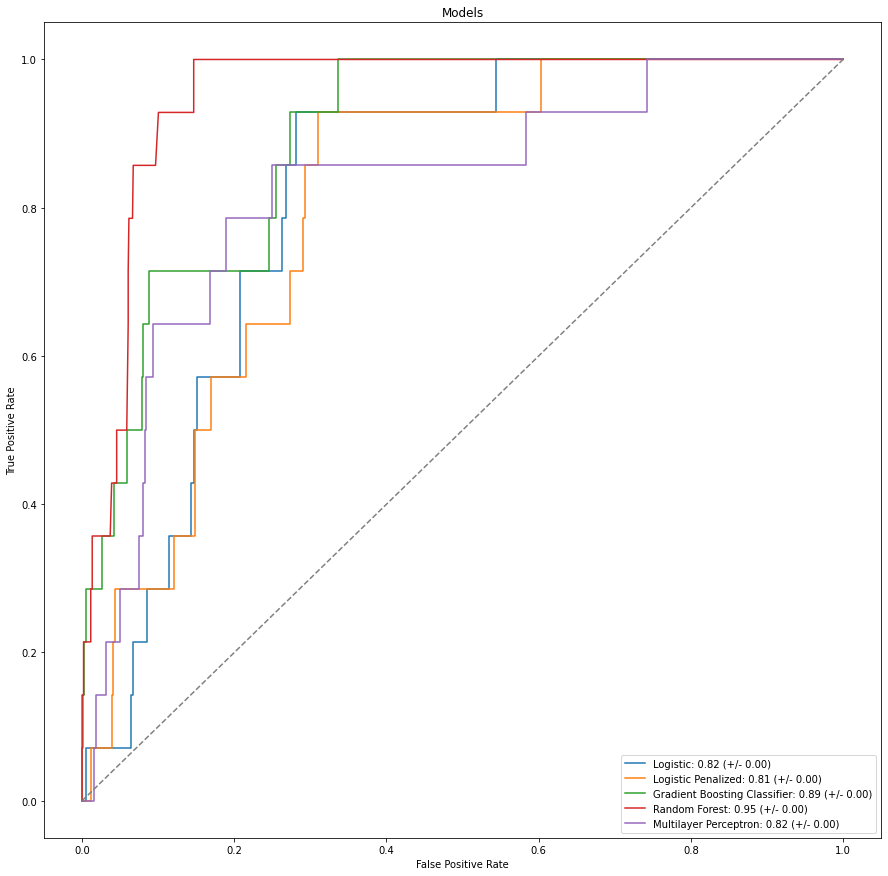

In [22]:
multi_plot_test('Models', models, test_datasets, modelNames, y_test)

In [11]:
def multi_plot_test(title, models, test_datasets, modelNames, y_test):
    fig, ax = plt.subplots(figsize=(15,15))
    
    for model, test_dataset, modelName in zip(models, test_datasets, modelNames):
        prediction = model.predict_proba(test_dataset)
        prediction = prediction[:, 1]  

        fpr, tpr, _ = roc_curve(y_test, prediction)
        roc_auc = auc(fpr, tpr)
        auc_score = roc_auc.mean()
        # Compute its standard deviation
        auc_std = roc_auc.std()

                # Plotting results
        ax.plot(fpr, tpr, label='{}: {:.2f} (+/- {:.2f})'.format(modelName, auc_score, auc_std*2))
        ax.set_title(title)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend()
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')

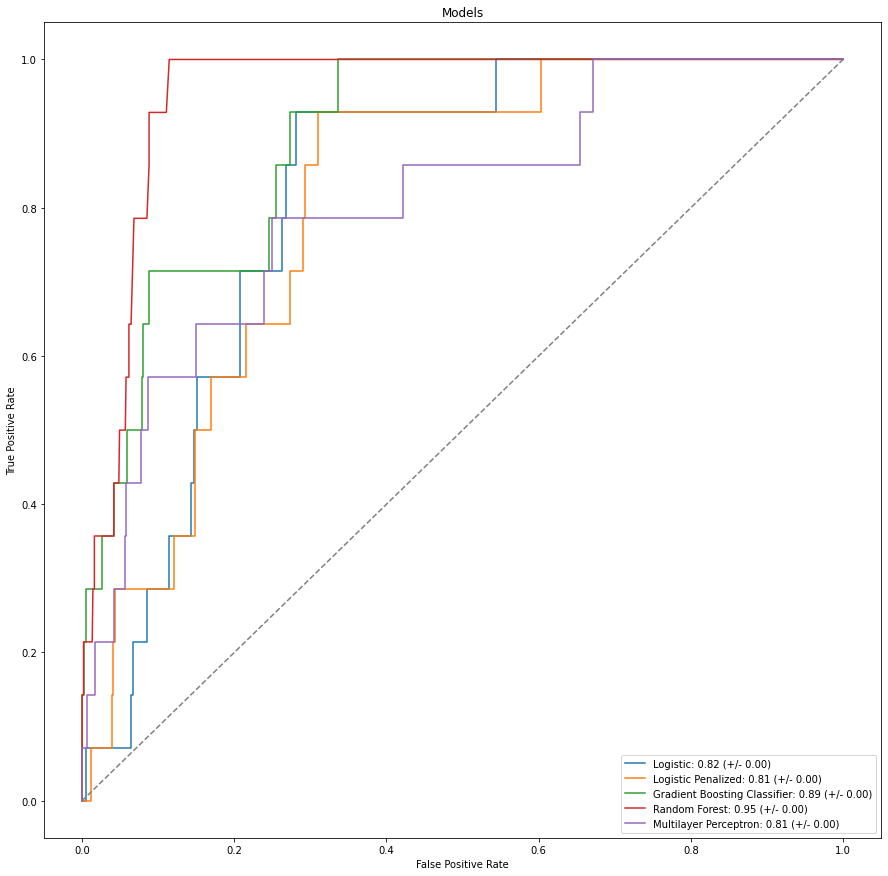

In [80]:
multi_plot_test('Models', models, test_datasets, modelNames, y_test)

In [ ]:
X_train_tensor = torch.tensor(X_res_train_scaled)

y_train_tensor = torch.tensor( y_res_train_scaled['warstds'].values)


y_test = pd.DataFrame(y_test.reset_index().drop("index", axis=1))

X_test_tensor = torch.tensor(X_test_scaled)
y_test_tensor = torch.tensor(y_test['warstds'].values)

train1 = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test1 = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Creating train and test dataloaders for this subset, with a batch size of 8

batchSize = 8

trainLoader1 = torch.utils.data.DataLoader(train1, batch_size = batchSize, shuffle = False)
testLoader1 = torch.utils.data.DataLoader(test1, batch_size = batchSize, shuffle = False)

In [33]:
X_train

,ptime,autonomy,popdense,army85,milper,trade,nmgdp,autch98,demch98,polch98,...,mirps1,mirps2,mirps3,sxpsq,pol4sq,decade1,decade2,decade3,decade4,proxregc
862,72,0.0,18.651319,9.000000e+03,1.000000,15.313420,2340.432617,0,0,0,...,0.0,1.0,0.0,0.052612,49.0,1,0,0,0,3.906250e-03
2325,228,0.0,43.196800,1.500000e+04,18.000000,40.127899,950.000000,0,0,0,...,1.0,0.0,0.0,0.046949,49.0,0,1,0,0,6.250000e-02
2377,270,0.0,68.510483,2.010000e+05,159.000000,23.462629,3116.260010,0,0,0,...,1.0,0.0,0.0,0.001214,49.0,0,1,0,0,1.562500e-02
6517,348,0.0,23.136391,2.244000e+06,2320.000000,11.967160,8231.500000,0,0,0,...,0.0,0.0,1.0,0.000141,100.0,0,1,0,0,0.000000e+00
4858,402,0.0,122.969101,4.830000e+05,479.000000,33.362629,2510.490234,0,0,0,...,1.0,0.0,0.0,0.000652,49.0,0,0,1,0,6.100000e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,24,0.0,6.176787,3.000000e+03,4.000000,86.143013,978.000000,0,0,0,...,0.0,0.0,1.0,0.158617,100.0,0,1,0,0,1.000000e+00
3264,240,0.0,199.658401,2.000000e+03,4.000000,102.107597,4517.909954,0,0,0,...,0.0,0.0,1.0,0.017232,100.0,0,0,1,0,2.270000e-13
1653,132,0.0,118.810138,1.305048e+05,120.964159,72.810553,4517.621928,0,0,0,...,0.0,0.0,1.0,0.052819,100.0,0,0,0,0,3.310000e-24
2607,156,0.0,119.734912,1.300435e+05,120.819112,72.855386,4513.655494,0,0,0,...,0.0,1.0,0.0,0.052993,25.0,0,0,0,0,2.441410e-04


In [38]:
X_train_tensor = torch.tensor(X_res_train_scaled)
y_res_train_scaled_df = pd.DataFrame(y_res_train_scaled)
y_train_tensor = torch.tensor( y_res_train_scaled_df['warstds'].values)


y_test = pd.DataFrame(y_test.reset_index().drop("index", axis=1))

X_test_tensor = torch.tensor(X_test_scaled)
y_test_tensor = torch.tensor(y_test['warstds'].values)

train1 = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test1 = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Creating train and test dataloaders for this subset, with a batch size of 8

batchSize = 8

trainLoader1 = torch.utils.data.DataLoader(train1, batch_size = batchSize, shuffle = False)
testLoader1 = torch.utils.data.DataLoader(test1, batch_size = batchSize, shuffle = False)

In [71]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        # Number of input features is 12.
        self.layer_1 = nn.Linear(90, 512) 
        self.layer_2 = nn.Linear(512, 512)
        self.layer_3 = nn.Linear(512, 256)
        self.layer_4 = nn.Linear(256, 128)
        self.layer_out = nn.Linear(128, 1) 
        
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.batchnorm4 = nn.BatchNorm1d(128)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout1(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout2(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.dropout3(x)
        x = self.layer_out(x)
        
        return x


In [28]:
def binary_acc(y_pred, y_test):
    
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

def fit(model, train_loader, device, EPOCHS=50, LEARNING_RATE=0.001):
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    model.train()
    for e in range(1, EPOCHS+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            
            X_batch = Variable(X_batch).float()
            y_batch = Variable(y_batch)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.float().unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.float().unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')


In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = binaryClassification()
model.to(device)

fit(model, trainLoader1, device, 30)

Epoch 001: | Loss: 0.20257 | Acc: 93.870
Epoch 002: | Loss: 0.25255 | Acc: 92.166
Epoch 003: | Loss: 0.25238 | Acc: 91.881
Epoch 004: | Loss: 0.25364 | Acc: 91.983
Epoch 005: | Loss: 0.25475 | Acc: 91.872
Epoch 006: | Loss: 0.25718 | Acc: 91.923
Epoch 007: | Loss: 0.26254 | Acc: 91.412
Epoch 008: | Loss: 0.26626 | Acc: 91.319
Epoch 009: | Loss: 0.26681 | Acc: 91.060
Epoch 010: | Loss: 0.27034 | Acc: 91.025
Epoch 011: | Loss: 0.26903 | Acc: 91.105
Epoch 012: | Loss: 0.27223 | Acc: 90.865
Epoch 013: | Loss: 0.27372 | Acc: 90.851
Epoch 014: | Loss: 0.27299 | Acc: 90.572
Epoch 015: | Loss: 0.27536 | Acc: 90.534
Epoch 016: | Loss: 0.26942 | Acc: 90.930
Epoch 017: | Loss: 0.26443 | Acc: 91.090
Epoch 018: | Loss: 0.26096 | Acc: 91.208
Epoch 019: | Loss: 0.26027 | Acc: 91.529
Epoch 020: | Loss: 0.25814 | Acc: 91.453
Epoch 021: | Loss: 0.25031 | Acc: 91.754
Epoch 022: | Loss: 0.24781 | Acc: 92.078
Epoch 023: | Loss: 0.24425 | Acc: 92.184
Epoch 024: | Loss: 0.23557 | Acc: 92.466
Epoch 025: | Los

In [42]:
def test_nn_model(model, testLoader ):
    y_pred_list = []
    y_tag_list = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in testLoader:
            X_batch = Variable(X_batch).float()
            y_batch = Variable(y_batch)
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_test_pred.cpu().numpy())
            y_tag_list.append(y_pred_tag.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_tag_list = [a.squeeze().tolist() for a in y_tag_list]
    return y_tag_list, y_pred_list


In [77]:
tag_list, pred_list = test_nn_model(model, testLoader1)

In [61]:
pred_list

[[0.998188316822052,
  1.0,
  1.0,
  0.9984583854675293,
  1.0,
  0.9971709847450256,
  1.0,
  0.9983528852462769],
 [1.0,
  0.9947531223297119,
  0.996535062789917,
  1.0,
  1.0,
  0.9974038004875183,
  1.0,
  1.0],
 [0.9954062700271606,
  0.9980090260505676,
  0.9958304762840271,
  1.0,
  0.9981772899627686,
  1.0,
  1.0,
  0.9965846538543701],
 [1.0,
  1.0,
  1.0,
  0.9964197874069214,
  0.9971333742141724,
  1.0,
  1.0,
  0.9966691136360168],
 [0.9982159733772278,
  0.9967142343521118,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9980522394180298,
  0.9973134398460388],
 [0.9952690005302429,
  0.9969480633735657,
  1.0,
  0.9973248243331909,
  0.9878782629966736,
  0.9975244402885437,
  1.0,
  0.9972948431968689],
 [0.9978534579277039,
  1.0,
  0.9972810745239258,
  1.0,
  1.0,
  1.0,
  0.9973672032356262,
  0.9897682070732117],
 [0.9968089461326599,
  0.9982274174690247,
  1.0,
  0.9982179999351501,
  1.0,
  0.9981299042701721,
  0.9970031380653381,
  1.0],
 [1.0,
  0.9979233145713806,
  1.0,


In [78]:

y_pred_NN = numpy.concatenate(pred_list, axis=0)

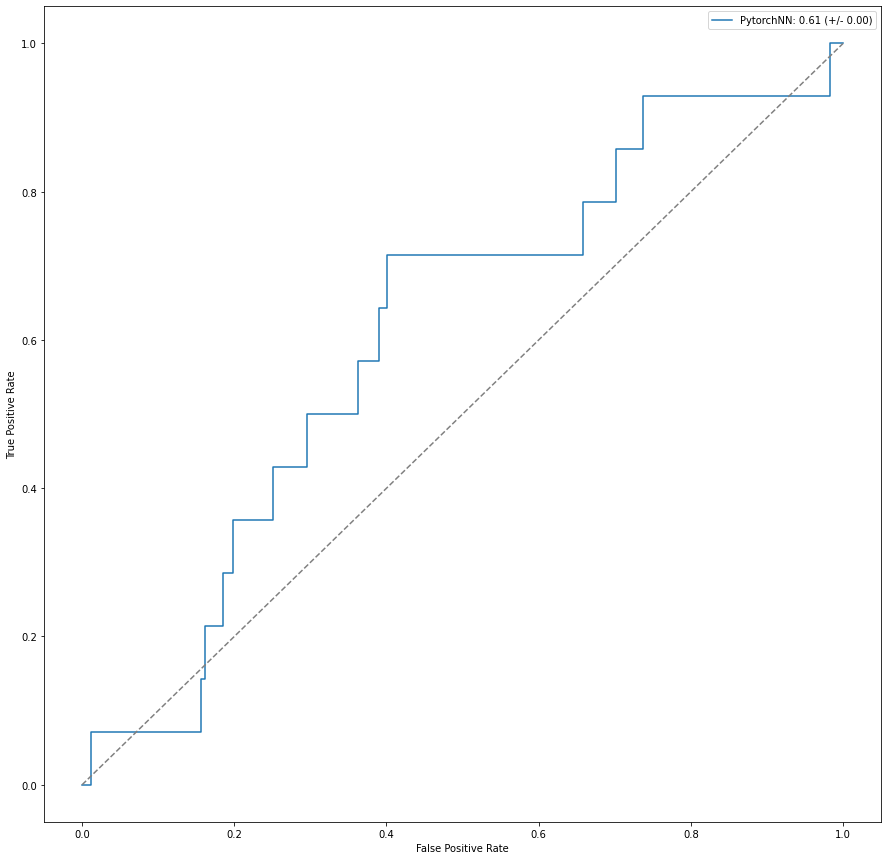

In [79]:
fpr, tpr, _ = roc_curve(y_test, y_pred_NN)
roc_auc = auc(fpr, tpr)
auc_score = roc_auc.mean()
        # Compute its standard deviation
auc_std = roc_auc.std()
fig, ax = plt.subplots(figsize=(15,15))
ax.plot(fpr, tpr, label='{}: {:.2f} (+/- {:.2f})'.format("PytorchNN", auc_score, auc_std*2))

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
ax.plot([0, 1], [0, 1], color='grey', linestyle='--')